In [ ]:
import pandas as pd
import numpy as np
import cv2
import os
from random import shuffle
from tqdm import tqdm
import random
from PIL import Image
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from random import shuffle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras import Model, layers
from numpy import loadtxt

import itertools
from sklearn.metrics import confusion_matrix,classification_report

from tensorflow.keras.applications.imagenet_utils import preprocess_input, decode_predictions
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Sample Images

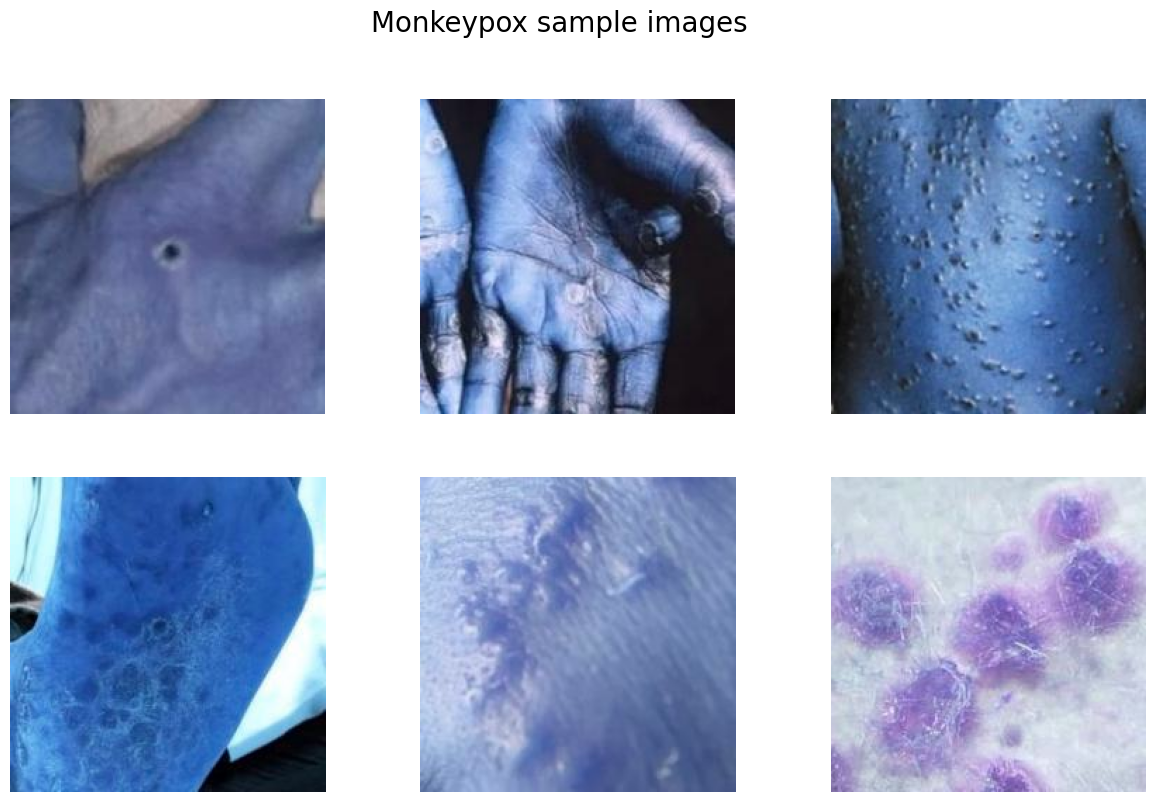

In [ ]:
M_DIR =  "/content/drive/MyDrive/Monkey_Pox_Dataset/Train/MonkeyPox/"
O_DIR = "/content/drive/MyDrive/Monkey_Pox_Dataset/Train/Others/"

Mimages = os.listdir(M_DIR)
Oimages = os.listdir(O_DIR)

sample_monkeypox = random.sample(Mimages,6)
f,ax = plt.subplots(2,3,figsize=(15,9))

for i in range(0,6):
    im = cv2.imread(M_DIR +sample_monkeypox[i])
    ax[i//3,i%3].imshow(im)
    ax[i//3,i%3].axis('off')
f.suptitle('Monkeypox sample images',fontsize=20)
plt.show()

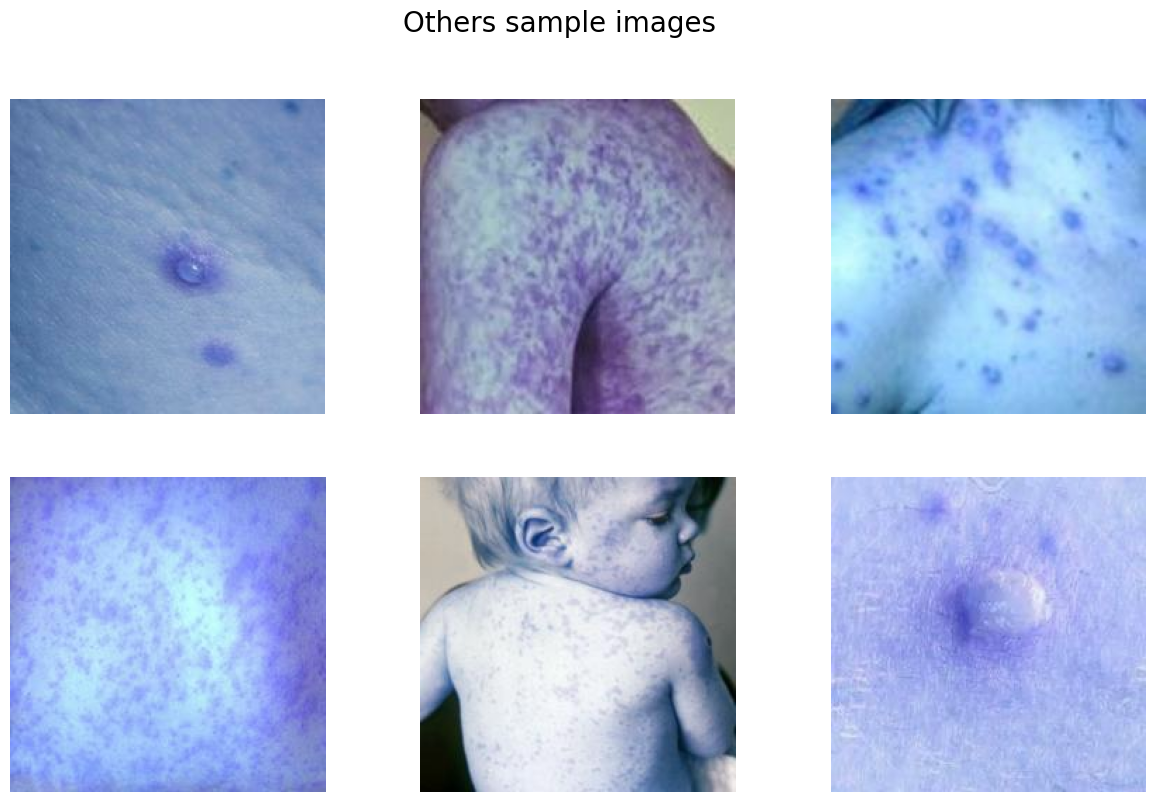

In [ ]:
Oimages = [f for f in os.listdir(O_DIR) if os.path.isfile(os.path.join(O_DIR, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg'))]


num_others_images = len(Oimages)


sample_size_others = min(num_others_images, 6)

# Sample the images
sample_others = random.sample(Oimages, sample_size_others)

f,ax = plt.subplots(2,3,figsize=(15,9))

for i in range(0, sample_size_others):
    im = cv2.imread(O_DIR +sample_others[i])
    ax[i//3,i%3].imshow(im)
    ax[i//3,i%3].axis('off')
f.suptitle('Others sample images',fontsize=20)
plt.show()

## Data Preparation - Loading Images and Labels

In [ ]:
data=[]
labels=[]
for m in Mimages:
    try:
        image=cv2.imread(M_DIR+m)
        image_from_array = Image.fromarray(image, 'RGB')
        size_image = image_from_array.resize((224, 224))
        data.append(np.array(size_image))
        labels.append(1)
    except AttributeError:
        print("")

for o in Oimages:
    try:
        image=cv2.imread(O_DIR+o)
        image_from_array = Image.fromarray(image, 'RGB')
        size_image = image_from_array.resize((224, 224))
        data.append(np.array(size_image))
        labels.append(0)
    except AttributeError:
        print("")

In [ ]:
#converting features and labels in array
feats=np.array(data)
labels=np.array(labels)

# saving features and labels for later re-use
np.save("/content/drive/MyDrive/Monkey_Pox_Dataset/feats_train",feats)
np.save("/content/drive/MyDrive/Monkey_Pox_Dataset/labels_train",labels)

In [ ]:
feats=np.load("/content/drive/MyDrive/Monkey_Pox_Dataset/feats_train.npy")
labels=np.load("/content/drive/MyDrive/Monkey_Pox_Dataset/labels_train.npy")

s=np.arange(feats.shape[0])
np.random.shuffle(s)
feats=feats[s]
labels=labels[s]

num_classes=len(np.unique(labels))
len_data=len(feats)
print(len_data)

228


In [ ]:
# splitting cells images into 80:20 ratio i.e., 80% for training and 20% for testing purpose
(x_train,x_test)=feats[(int)(0.2*len_data):],feats[:(int)(0.2*len_data)]

(y_train,y_test)=labels[(int)(0.2*len_data):],labels[:(int)(0.2*len_data)]

In [ ]:
x_train = x_train.astype('float32')/255 # As we are working on image data we are normalizing data by divinding 255.
x_test = x_test.astype('float32')/255
train_len=len(x_train)
test_len=len(x_test)


#Doing One hot encoding as classifier has multiple classes
y_train=to_categorical(y_train,num_classes)
y_test=to_categorical(y_test,num_classes)




In [ ]:
# Hyper parameters
epochs = 40
batch_size = 32

conv_base = MobileNetV2(
    include_top=False,
    weights='imagenet')

for layer in conv_base.layers:
    layer.trainable = True

<ipython-input-11-1327a8b0731a>:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  conv_base = MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
x = conv_base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(32, activation='relu')(x)
predictions = layers.Dense(2, activation='softmax')(x)
model = Model(conv_base.input, predictions)

In [ ]:
# Define the optimizer
#optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None, None, 3)  │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, None, None, 32) │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, None, None, 32) │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, None, None, 32) │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, None, None, 32) │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, None, None, 32) │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, None, None, 32) │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, None, None, 16) │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, None, None, 16) │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, None, None, 96) │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, None, None, 96) │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, None, None, 96) │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, None, None, 96) │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, None, None, 96) │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,930,338 (11.18 MB)

 Trainable params: 2,896,226 (11.05 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [ ]:
checkpoint = ModelCheckpoint('mdl_wts.keras', monitor='val_accuracy', verbose=1,
                             save_best_only=True, mode='max')
#filepath has been changed to mdl_wts.keras to ensure the model is saved in correct format.
#The .keras extension is used for saving the entire model, not just weights.

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2,
                                   verbose=1, mode='min', min_lr=0.0000001)



callbacks = [checkpoint,reduce_lr]

Epoch 1/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8082 - loss: 0.3853   
Epoch 1: val_accuracy improved from -inf to 0.57778, saving model to mdl_wts.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 66s 5s/step - accuracy: 0.8231 - loss: 0.3616 - val_accuracy: 0.5778 - val_loss: 14.7615 - learning_rate: 0.0010
Epoch 2/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.9865 - loss: 0.0504
Epoch 2: val_accuracy improved from 0.57778 to 0.60000, saving model to mdl_wts.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 247ms/step - accuracy: 0.9861 - loss: 0.0509 - val_accuracy: 0.6000 - val_loss: 19.2301 - learning_rate: 0.0010
Epoch 3/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.9588 - loss: 0.2531 
Epoch 3: val_accuracy improved from 0.60000 to 0.73333, saving model to mdl_wts.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 650ms/step - accuracy: 0.9561 - loss: 0.2549 - val_accuracy: 0.7333 - val_loss: 8.0960 - learning_rate: 0.0010
Epoch 4/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9303 - loss:

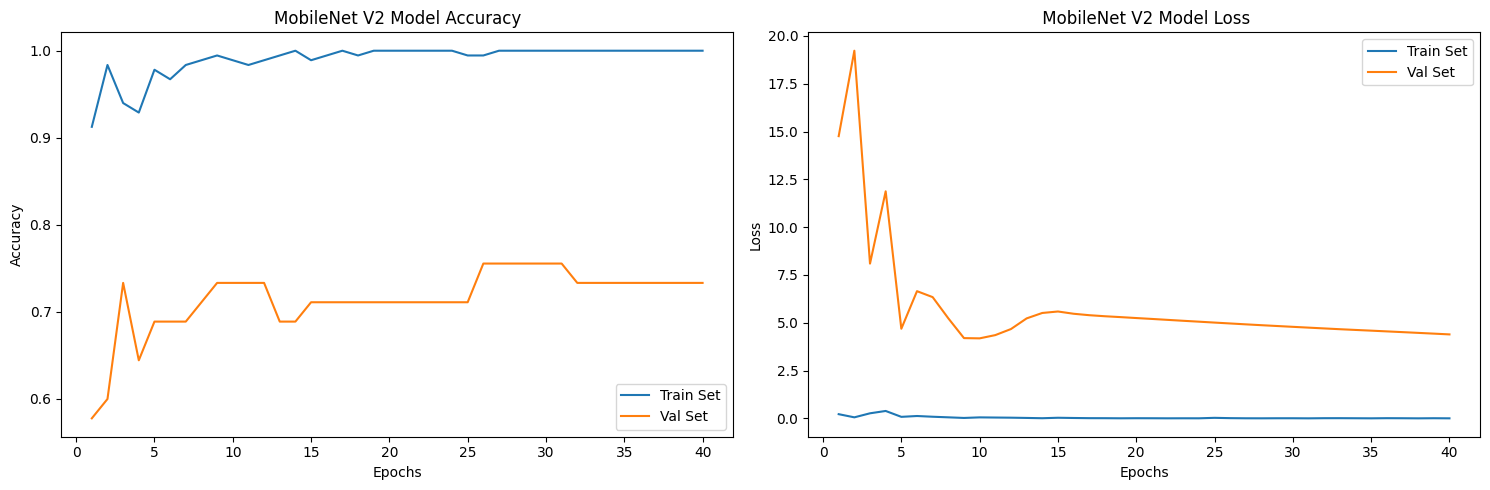

In [ ]:
# ipython-input-0-42e31f77359a
history = model.fit(x_train,y_train,batch_size=batch_size,callbacks=callbacks, validation_data=(x_test,y_test),epochs=epochs,verbose=1)

#--- Keep the next cell in the same notebook as the above cell (ipython-input-0-42e31f77359a)
#--- OR, move the plotting code to the same cell directly below model.fit

# ipython-input-47-42e31f77359a
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('MobileNet V2 Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(' MobileNet V2 Model Loss')

plt.tight_layout()
plt.show()

In [ ]:
# saving the weight of model
from keras.models import load_model
# Correct the file name to match the one specified in ModelCheckpoint
model = load_model('mdl_wts.keras')

# checking the score of the model
score = model.evaluate(x_test, y_test)
print(score)

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8042 - loss: 6.2375
[6.621337413787842, 0.800000011920929]


In [ ]:
x_val=np.load("/content/drive/MyDrive/Monkey_Pox_Dataset/feats_train.npy")
y_val=np.load("/content/drive/MyDrive/Monkey_Pox_Dataset/labels_train.npy")

s=np.arange(x_val.shape[0])
np.random.shuffle(s)
x_val=x_val[s]
y_val=y_val[s]

x_val = x_val.astype('float32')/255
y_val=to_categorical(y_val,num_classes)

In [ ]:
# checking the accuracy of thr
accuracy = model.evaluate(x_val, y_val, verbose=1)
print('\n', 'Validation_Accuracy:-', accuracy[1])

8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.5422 - loss: 1.8443

 Validation_Accuracy:- 0.5526315569877625


8/8 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step


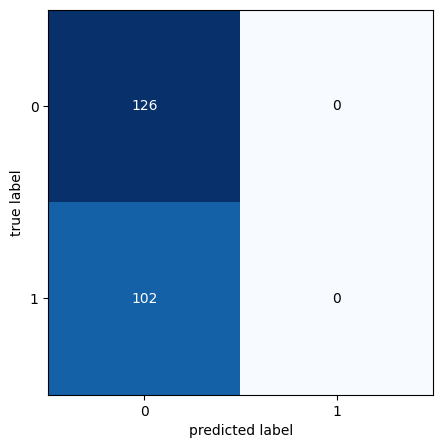

In [ ]:
from sklearn.metrics import confusion_matrix
pred = model.predict(x_val)
pred = np.argmax(pred,axis = 1)
y_true = np.argmax(y_val,axis = 1)

#creating confusion matrix
CM = confusion_matrix(y_true, pred)
from mlxtend.plotting import plot_confusion_matrix
# plotting confusion matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

In [ ]:
print('{}'.format(
                           classification_report(y_true , pred)))

              precision    recall  f1-score   support

           0       0.55      1.00      0.71       126
           1       0.00      0.00      0.00       102

    accuracy                           0.55       228
   macro avg       0.28      0.50      0.36       228
weighted avg       0.31      0.55      0.39       228



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 901ms/step


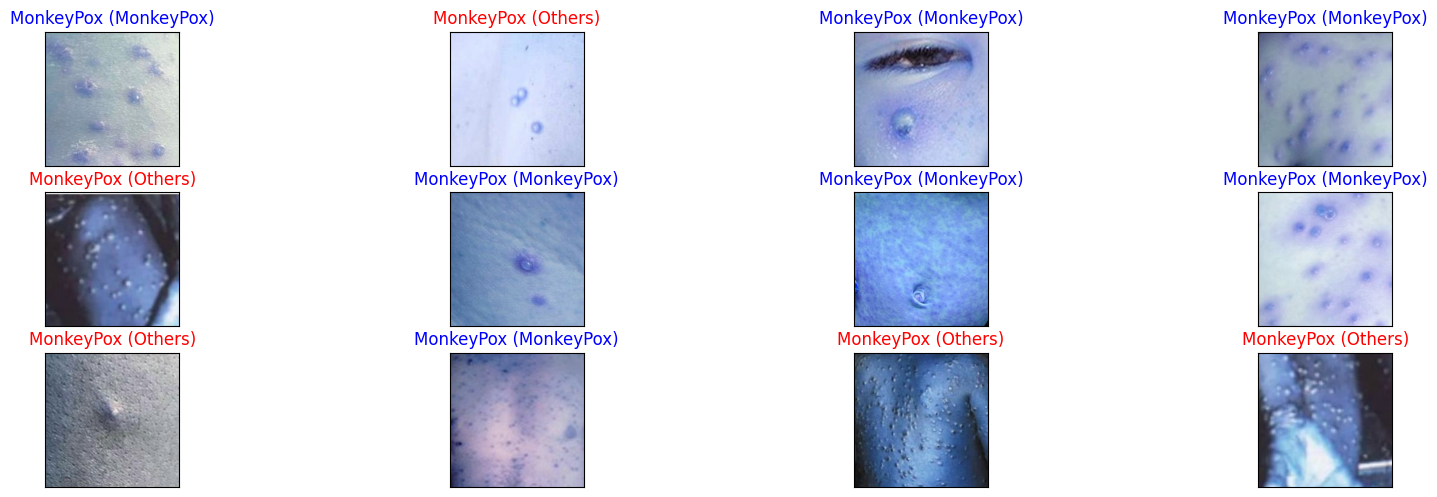

In [ ]:
y_hat = model.predict(x_val)

# define text labels
m_labels = ['MonkeyPox','Others']

# plot a random sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(x_val.shape[0], size=12, replace=False)):
    ax = fig.add_subplot(4,4, i+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_val[idx]))
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(y_val[idx])
    ax.set_title("{} ({})".format(m_labels[pred_idx], m_labels[true_idx]),
                 color=("blue" if pred_idx == true_idx else "red"))